## Overview of the notebook 

This notebook contains all code used to produce the Figures 1 and 4 for the paper "Computing the Bias of Constant-step Stochastic Approximation with Markovian Noise"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


## Define drift, average drift and steady-state

In [2]:
def transition_matrix_y(x):
    matrix = np.array([
        [1-x/2, x/2],
        [x/2, 1-x/2]
    ])
    return matrix

def drift(x,y):
    return 2*y - x

def avg_drift(x, t=None):
    _avg_drift = 0.
    for y in y_states:
        _avg_drift += pi(x,y) * drift(x,y)
    return _avg_drift



def pi(x,y): # get steady-state probabilities
    _P = transition_matrix_y(x)
    _pi_1 = (1 - _P[0,0]) / ( 2 - _P[0,0] - _P[1,1] )
    _pi_0 = (1 - _P[1,1]) / ( 2 - _P[0,0] - _P[1,1] )
    
    return _pi_0 if y == 0 else _pi_1

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float) 
    ret[n:] = ret[n:] - ret[:-n] # calculate the sum over the n consecutive terms 
    return ret[n - 1:] / n # normalize and return

def average_increasing_T(a):
    ret = np.cumsum(a, dtype=float) 
    return ret / np.arange(1, ret.shape[0]+1)

def average_increasing_T2(a, shape=0):
    ret = np.cumsum(a, dtype=float) 
    res = np.zeros(len(ret))
    for i in range(len(ret)):
        res[i] = (ret[i]-ret[int(i*shape)])/(i-int(i*shape))
    return res

In [3]:
from copy import copy

def simulate(alpha, t_max, t_start, t_end, x_init, y_init, y_transition_matrix, y_states, noise=True, seed=None, **averages_parameters,):
    # assert np.dot(np.array([pi(0,0), pi(0,1)]), transition_matrix_y(x_init)).all(), f'Steady-State not correct'

    if seed is not None:
        np.random.seed(seed)
    
    t_interval = np.linspace(0,np.min([t_max, 1000]), num=2000)
    ode_value = odeint(avg_drift, x_init, t_interval)
    t_interval_2 = np.linspace(0, 1000, num=20000)
    ode_value_fixpoint = odeint(avg_drift, ode_value[-1], t_interval)[0]
    
    if averages_parameters:
        if int(t_max/alpha) < (np.max(list(averages_parameters.values())) + 1000): # increase t_max in case it is to small to obtain average
            t_max = int(np.max(list(averages_parameters.values())) * alpha + 1000)
            print(f'Increased t_max to {t_max}')

    t_stoch = np.linspace(0, t_max, num=int(t_max/alpha)+1)
    process_values = []

    _x_n = x_init
    _y_n = y_init
    
    process_values.append(x_init)
    y_value_index_map = {y :i for i,y in enumerate(y_states)}

    if averages_parameters:
        avg_extension = np.max(list(averages_parameters.values()))
    else:
        avg_extension = 0
    for _ in np.arange(0,t_max + avg_extension): #int(t_max/alpha)):
        # make transitions
        _y_n_plus_1 = np.random.choice(y_states, p=transition_matrix_y(_x_n)[y_value_index_map[_y_n]])
        # print(_y_n_plus_1)
        _x_n_plus_1 = _x_n + alpha * (drift(_x_n, _y_n_plus_1) + (4*(np.random.rand()-0.5) if noise else 0))
        # append value
        process_values.append(copy(_x_n_plus_1))
        # replace values
        _x_n = _x_n_plus_1
        _y_n = _y_n_plus_1

    process_values = np.array(process_values)

    return ode_value_fixpoint, process_values
    



The following code simulates trajectories of 1.1e5 steps. This takes a bit of time (<1min)

In [4]:
def transition_matrix_y(x):
    matrix = np.array([
        [np.sin(x)**2, np.cos(x)**2],
        [np.cos(x)**2, np.sin(x)**2]
    ])
    # matrix = np.array([
    #     [0.8, 0.2],
    #     [0.2, 0.8]
    # ])
    return matrix

def drift(x,y):
    return 2*y - x

x_init = 3

t_start = 00000
t_end= 60000
t_max= 100000

y_states = [0, 1]
    
y_init = y_states[0]


# check if stedy-state is correct
# (np.array([pi(1,0), pi(1,1)]) == np.dot(np.array([pi(1,0), pi(1,1)]), transition_matrix_y(x_init))).all()

seeds = [0] # We could use multiple seeds but we only use one!
alphas = [0.02, 0.01, 0.005, 0.0025, 0.00125, 0.000625] #, 0.002, 0.001]
T = [10000]

def get_simulation_value(alpha, seed, T=10000):
    filename = 'data/simulation_alpha{}_seed{}_T{}.npz'.format(alpha, seed, T)
    try:
        process_values = np.load(filename)['arr_0']
    except:
        ode_fixpoint, process_values = simulate(alpha=alpha, t_max=t_max, t_start=t_start, t_end=t_end, x_init=x_init, y_init=y_init, 
                           y_transition_matrix=transition_matrix_y, y_states=y_states, seed=seed, T1=T )
        np.savez_compressed(filename, process_values)
    return process_values
    
for alpha in alphas:
    for seed in seeds:
        get_simulation_value(alpha, seed, 10000)
    print(alpha)

0.02
0.01
0.005
0.0025
0.00125
0.000625


We compute the various quantities to be plotted

In [5]:
# The code for "values" was use to perform an average over multiple seed. We now use only one seed.
thetas = dict([])        # vector of \theta_n for a given theta
bar_thetas = dict([])    # vector of \bar{\theta}_n 
bar_thetas_n2 = dict([]) # vector of \bar{\theta}_{n:n/2}
rr_extrapolation = dict([]) # vector of 2\bar{\theta}_{n:n/2}^{(2*alpha)} - \bar{\theta}_{n:n/2}^{(alpha)}
colors = dict([])        # colors (to be consistent for various plots)
for i, alpha in enumerate(alphas):
    thetas[alpha] = np.mean([get_simulation_value(alpha, seed, 10000) for seed in seeds], 0)
    bar_thetas[alpha] = average_increasing_T2(thetas[alpha], 0)
    bar_thetas_n2[alpha] = average_increasing_T2(thetas[alpha], 0.5)
    if i>=1:
        rr_extrapolation[alpha] = 2*bar_thetas_n2[alpha] - bar_thetas_n2[2*alpha]
    colors[alpha] = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]

print(colors)


/var/folders/1_/p5wrxxh10ds1d_5qxhrgkfd00000gn/T/ipykernel_86342/2325242335.py:39: RuntimeWarning: invalid value encountered in scalar divide
  res[i] = (ret[i]-ret[int(i*shape)])/(i-int(i*shape))


{0.02: '#1f77b4', 0.01: '#ff7f0e', 0.005: '#2ca02c', 0.0025: '#d62728', 0.00125: '#9467bd', 0.000625: '#8c564b'}


# Figure 1: $\theta$ vs $\bar{\theta}$ vs Extrapolation

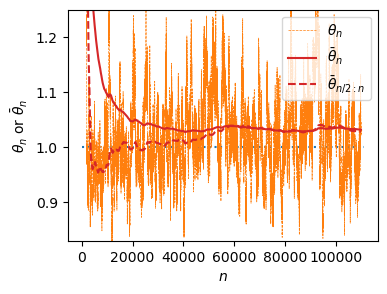

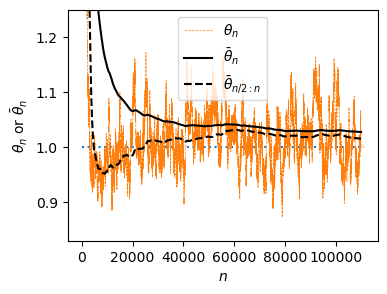

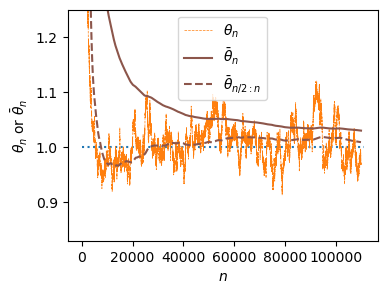

In [6]:
alphas = [0.02, 0.01, 0.005, 0.0025, 0.00125, 0.000625] #, 0.002, 0.001]

position = [.58, .17]
def do_plot(i, alpha, ylim=[0.83, 1.25]):
    plt.plot([0, 1.11e5], [1, 1], ':')
    plt.plot(thetas[alpha], '--', lw=0.5, label=r'$\theta_n$')#^{'+'({})'.format(alpha)+'}$')
    plt.plot(bar_thetas[alpha], color=colors[alpha] if i!=1 else '#000000', label=r'$\bar{\theta}_n$')#^{'+'({})'.format(alpha)+'}$')
    plt.plot(bar_thetas_n2[alpha], '--', color=colors[alpha] if i!=1 else '#000000', label=r'$\bar{\theta}_{n/2:n}$')#^{'+'({})'.format(alpha)+'}$')
    plt.legend()
    plt.xlabel(r'$n$')
    plt.ylabel(r'$\theta_n$ or $\bar{\theta}_n$')
    plt.ylim(ylim)

for i, alpha in enumerate([0.0025, 0.00125, 0.000625]):
    fig = plt.figure(figsize=(4, 3))
    #ax = plt.subplot(2, 1, i+1)
    do_plot(i, alpha)
    fig.savefig('../figs/traj_SA_thetaBar_{}.pdf'.format(i), bbox_inches='tight')



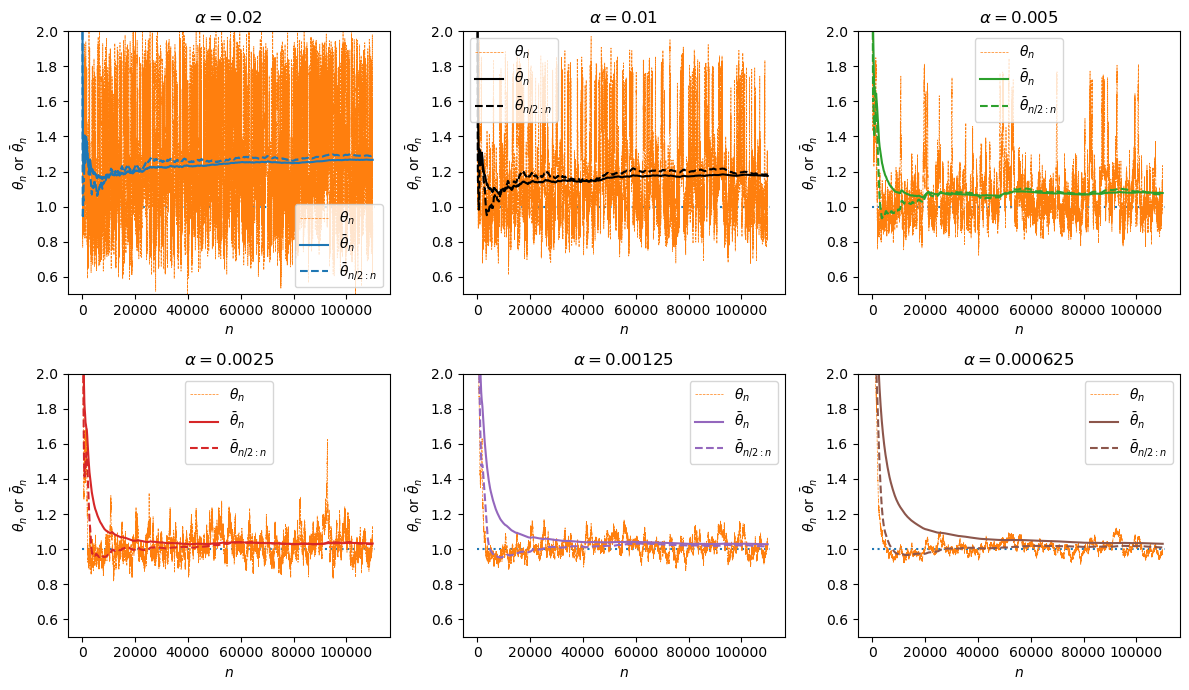

In [7]:
fig = plt.figure(figsize=(12, 7))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(2, 3, i+1)
    do_plot(i, alpha, ylim=[0.5, 2])
    ax.set_title(r'$\alpha={}$'.format(alpha))
plt.tight_layout()
fig.savefig('../figs/traj_SA_thetaBar_all.pdf', bbox_inches='tight')


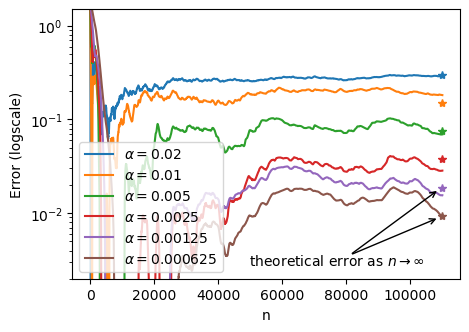

In [8]:
fig = plt.figure(figsize=(5, 3.5))
ax = plt.subplot()
for i, alpha in enumerate(alphas):
    plt.semilogy(bar_thetas_n2[alpha]-1, color=colors[alpha], label=r'$\alpha={}$'.format(alphas[i]))
    plt.plot([110000],15*alpha,'*', color=colors[alpha])

plt.legend()
plt.ylim(2e-3, 1.5)
plt.xlabel('n')
plt.ylabel('Error (logscale)')
ax.annotate(r'theoretical error as $n\to\infty$',
            xy=(108000,18e-3),
            xytext=(0.85, 0.19),
            textcoords='figure fraction',
            horizontalalignment='right')
ax.annotate('',
            xy=(109000,9e-3), 
            xytext=(0.7, 0.22),    # fraction, fraction
            textcoords='figure fraction',
            arrowprops=dict(arrowstyle="->")
           )
ax.annotate('',
            xy=(109000,18e-3), 
            xytext=(0.7, 0.22),    # fraction, fraction
            textcoords='figure fraction',
            arrowprops=dict(arrowstyle="->")
           )
#plt.arrow(90000,8e-3,20000,0.01)
fig.savefig('../figs/stoch_approx_avg_error.pdf', bbox_inches='tight')


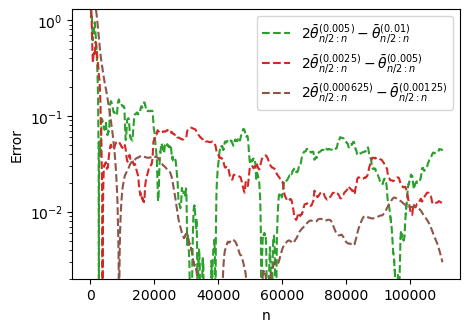

In [9]:
fig = plt.figure(figsize=(5, 3.5))
#for alpha in [0.01, 0.005]:
#    plt.semilogy(np.abs(bar_thetas_n2[alpha]-1), color=colors[alpha], label=r'$\alpha={}$'.format(alpha))
for alpha in [0.005, 0.0025, 0.000625]:
    plt.semilogy(np.abs(rr_extrapolation[alpha]-1), '--', color=colors[alpha],
                 label=r'$2\bar{\theta}_{n/2:n}^{('+str(alpha)+r')} - \bar{\theta}_{n/2:n}^{('+str(2*alpha)+')}$')
plt.xlabel('n')
plt.ylabel('Error')
plt.ylim(2e-3, 1.3)
plt.legend()
fig.savefig('../figs/stoch_approx_avg_extrapolation.pdf', bbox_inches='tight')

## Plot with larger time (not in the paper)
What we gain in terms of noise reduction is not that clear.

/var/folders/1_/p5wrxxh10ds1d_5qxhrgkfd00000gn/T/ipykernel_86342/2325242335.py:39: RuntimeWarning: invalid value encountered in scalar divide
  res[i] = (ret[i]-ret[int(i*shape)])/(i-int(i*shape))


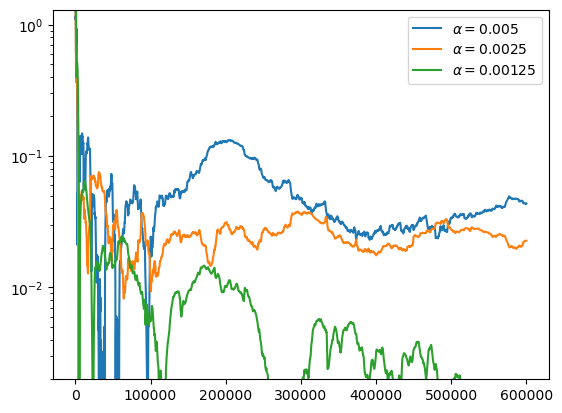

In [10]:
for alpha in [0.005, 0.0025, 0.00125]:
    V1 = average_increasing_T2(get_simulation_value(alpha, 0, 500000), 0.5)[::100]
    V2 = average_increasing_T2(get_simulation_value(2*alpha, 0, 500000), 0.5)[::100]
    plt.semilogy(np.arange(len(V1))*100,np.abs(2*V1-V2-1), label=r'$\alpha={}$'.format(alpha))
plt.ylim(2e-3, 1.3) # yscale is the same as before
plt.legend()

## Periodic $Y$

[-1.5        -0.925      -1.055      -0.837125   -0.90273    -0.76038083
 -0.80086521 -0.69318136 -0.72121175 -0.63418152 -0.65523942 -0.58223919
 -0.59909102 -0.53638321 -0.5505619  -0.4957866  -0.50819571 -0.45974413
 -0.47093973 -0.42765347 -0.43798869 -0.39899937 -0.40870381 -0.37334037
 -0.38256608 -0.35029757 -0.35914678 -0.32954524 -0.33808759 -0.31080287
 -0.31908637 -0.29382843 -0.30188663 -0.27841273 -0.28626942 -0.26437463
 -0.27204697 -0.25155695 -0.25905763 -0.23982307 -0.24716172 -0.22905399
 -0.23623816 -0.21914584 -0.22618167 -0.21000777 -0.21690046 -0.2015602
 -0.2083143  -0.19373321 -0.20035283 -0.18646529 -0.19295426 -0.17970219
 -0.18606411 -0.17339596 -0.17963432 -0.16750415 -0.17362231 -0.16198908
 -0.16799033 -0.15681725 -0.1627048  -0.15195878 -0.15773578 -0.14738702
 -0.15305655 -0.14307809 -0.14864318 -0.13901059 -0.14447418 -0.13516528
 -0.14053028 -0.13152486 -0.13679407 -0.12807368 -0.13324987 -0.12479764
 -0.12988347 -0.12168394 -0.12668202 -0.11872096 -0.

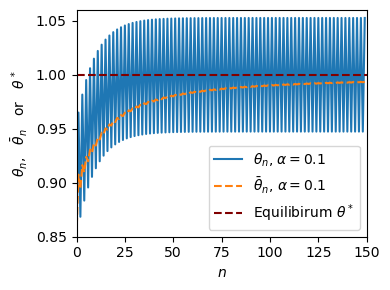

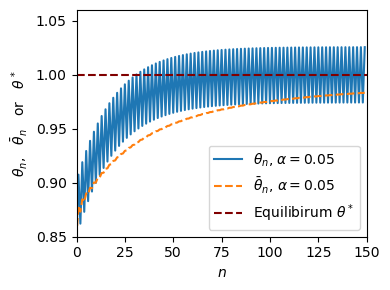

In [11]:
%matplotlib inline
import matplotlib


def transition_matrix_y(x):
    matrix = np.array([
        [0., 1.],
        [1., 0.]
    ])
    return matrix
t_start = 0
t_end = 150
y_states = [0, 1]
y_init = y_states[0]
x_init = 0.85

def drift(x,y):
    return 2*y - x


seeds = [0, 0]

for alpha in [0.1, 0.05]:
    alphas = [alpha]

    fig = plt.figure(figsize=(4, 3))

    for i in range(len(alphas)):
        ode_fixpoint, process_values = simulate(alpha=alphas[i], t_max=t_max, t_start=t_start, t_end=t_end, x_init=x_init, y_init=y_init, 
                           y_transition_matrix=transition_matrix_y, y_states=y_states, seed=seed, T1=10, noise=False )
        theta = process_values[0:150]
        theta_bar = average_increasing_T(theta)
        
        # ax = axes[i]
        #ode_fixpoint, theta, theta_bar = calculate_and_plot(ax=plt, alpha=alphas[i], t_max=1000, t_start=t_start, t_end=t_end, x_init=x_init, y_init=y_init, 
        #                   y_transition_matrix=transition_matrix_y, y_states=y_states, seed=seeds[i], show_Xk=True, plot=False) # , T2=1000, T3=5000)
        #                   # T1=int(1/alpha), T2=int(10/alpha), T3=int(100/alpha))
        plt.plot(theta, label=r'$\theta_n$, $\alpha={}$'.format(alphas[i]))
        plt.plot(theta_bar, '--', label=r'$\bar{\theta}_n$, '+r'$\alpha={}$'.format(alphas[i]))
    
    plt.hlines(ode_fixpoint, t_start, t_end, linestyles='dashed', label=r'Equilibirum $\theta^*$', alpha=1., color='maroon')
    
    # ax.set_title(fr'$\alpha$ = {alphas[i]}', fontsize=20)
    plt.ylabel(r'$\theta_n$,   $\bar{\theta}_n$   or   $\theta^*$')
    plt.xlabel(r'$n$')
    plt.xlim(0, 150)
    plt.ylim(0.85, 1.06)
    # plot parameters
    plt.legend(loc='best')
    plt.tight_layout()
    print( (theta_bar-1)/alpha )
    plt.savefig('../figs/stoch_approx_periodic_example_{:d}.pdf'.format(int(alpha*1000)), bbox_inches='tight')


